In [47]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


In [48]:
# load dataset
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Adjust the class distribution to ensure the model learns adequately about the minority class
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [49]:
# hyperparameter search for random forest

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [20, 30, 40, 50, 60, 70, 80],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 300}
0.9194346588952754


Threshold: 0.06 Recall: 0.9735 Accuracy: 0.5692
Threshold: 0.07 Recall: 0.9690 Accuracy: 0.5847
Threshold: 0.08 Recall: 0.9602 Accuracy: 0.6201
Threshold: 0.09 Recall: 0.9513 Accuracy: 0.6568
Threshold: 0.10 Recall: 0.9336 Accuracy: 0.6723
Threshold: 0.11 Recall: 0.9204 Accuracy: 0.6907
Threshold: 0.12 Recall: 0.9204 Accuracy: 0.7133
Threshold: 0.13 Recall: 0.9115 Accuracy: 0.7189
Threshold: 0.14 Recall: 0.9027 Accuracy: 0.7387
Threshold: 0.15 Recall: 0.8894 Accuracy: 0.7514
Threshold: 0.16 Recall: 0.8805 Accuracy: 0.7641
Threshold: 0.17 Recall: 0.8673 Accuracy: 0.7768
Threshold: 0.18 Recall: 0.8628 Accuracy: 0.7867
Threshold: 0.19 Recall: 0.8584 Accuracy: 0.7966
Threshold: 0.20 Recall: 0.8407 Accuracy: 0.7952


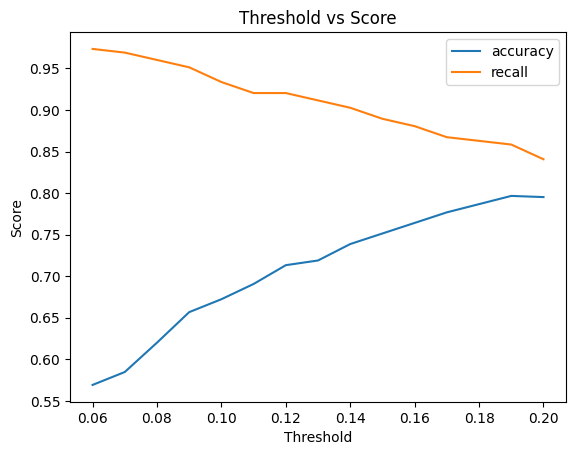

In [50]:
# hyper-parameter search for threshold

rf = RandomForestClassifier(n_estimators=300, max_depth=50, criterion='entropy', class_weight="balanced", random_state=42)

# split the training data into training and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf.fit(X_train_sub, y_train_sub)
y_pred_prob = rf.predict_proba(X_val)[:,1]

accuracies = []
recalls = []
for threshold in np.arange(0.06, 0.2, 0.01):
    y_pred = (y_pred_prob > threshold).astype(int)
    print('Threshold: {:.2f} Recall: {:.4f} Accuracy: {:.4f}'.format(threshold, recall_score(y_val, y_pred), accuracy_score(y_val, y_pred)))
    accuracies.append(accuracy_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))

plt.plot(np.arange(0.06, 0.2, 0.01), accuracies, label='accuracy')
plt.plot(np.arange(0.06, 0.2, 0.01), recalls, label='recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Score')
plt.show()



In [51]:
# use cross validation to evaluate random forest model consistency on X_train data
rf = RandomForestClassifier(n_estimators=300, max_depth=50, criterion='entropy', class_weight="balanced", random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='recall')
print("recall mean:", scores.mean(), "reacall std:", scores.std())

scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

recall mean: 0.7022440622440623 reacall std: 0.033185892973645936
accuracy mean: 0.8765192618556041 accuracy std: 0.00837716216847345


In [52]:
# classfication with random forest
rf = RandomForestClassifier(n_estimators=300, max_depth=50, criterion='entropy', class_weight="balanced", random_state=42)

# train random forest
rf.fit(X_train, y_train)

# Predict probabilities instead of classes
y_prob = rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (dropout)

# Adjust the decision threshold
threshold = 0.16
y_pred = (y_prob >= threshold).astype(int)

# evaluate accuracy, precision, recall, f1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Precision: ', precision)

# confusion matrix
print("")
print("confusion matrix: [TP, FP], [FN, TN]")
print(confusion_matrix(y_test, y_pred))


Recall:  0.8955696202531646
Accuracy:  0.7548022598870057
F1:  0.722860791826309
Precision:  0.6059957173447538

confusion matrix: [TP, FP], [FN, TN]
[[385 184]
 [ 33 283]]


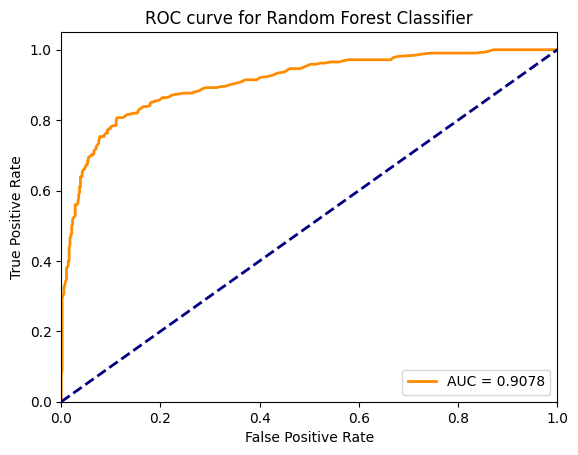

In [53]:
# build a ROC curve with different settings of decision tree
# then plot the ROC curve: false positive rate vs true positive rate
y_pred_prob = rf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()